### Setup

In [1]:
import sys,importlib
import torch
import torch.nn.functional as F

import os
import time
from tqdm import tqdm
import random
import numpy as np
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
import plotly.express as px

#import pykeops
#pykeops.clean_pykeops()

%matplotlib inline 

In [2]:
try:
    importlib.reload(sys.modules['dmasif_surface'])
    importlib.reload(sys.modules['data'])

except KeyError:
    pass
from dmasif_surface import atoms_to_points_normals
from data import AtomSurfaceDataset
from losses import chamfer_distance
from IPython.display import clear_output

### Оптимизируем параметры dmasif для тяжелых атомов

In [ ]:
dataset=AtomSurfaceDataset(storage='structure_data.pkl') 

In [ ]:
xs=[]
for data in tqdm(dataset):
    xs.append((data['atom_rad']>1.2).sum().item()/data['atom_rad'].shape[0])

print(np.mean(xs))
print(20/np.mean(xs))

Установим sup_sampling=34 чтобы скомпенсировать кол-во точек, генерируемых на каждый атом водорода.

In [ ]:
def comp_loss(dataset, args):
    ch_losses=[]
    norm_losses=[]
    sizes=[]
    for data in tqdm(dataset):
        xyz=data['atom_xyz'][data['atom_rad']>1.2]
        rad=data['atom_rad'][data['atom_rad']>1.2]*100
        #xyz=data['atom_xyz']
        #rad=data['atom_rad']*100
        try:
            dmasif_vert, dmasif_norm, _ = atoms_to_points_normals(xyz, 
                                                       torch.zeros(xyz.shape[0], dtype=int), 
                                                        atom_rad=rad,
                                                        **args)
            d_ch_loss, d_norm_loss=chamfer_distance( dmasif_vert, data['target_xyz'], 
                                             dmasif_norm, data['target_normals'])
        except RuntimeError:
            continue
        ch_losses.append(d_ch_loss)
        norm_losses.append(d_norm_loss)
        sizes.append(dmasif_vert.shape[0])
    return ch_losses, norm_losses, sizes


In [ ]:
ch=[]
no=[]
ss=[]
par=[1,1.05,1.1,1.15,1.2,1.25,1.3,1.35]
for parameter in par:
    args={'smoothness':0.5,'distance':parameter, 'sup_sampling':34, 'variance': 0.1 }
    a, b, c=comp_loss(dataset[:103], args)
    ch.append(np.mean(a))
    no.append(np.mean(b))
    ss.append(np.mean(c))
    clear_output()
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.title('chamfer')
    plt.plot(par[:len(ch)],ch, label='chamfer')
    plt.subplot(132)
    plt.title('normal')
    plt.plot(par[:len(no)],no, label='normal')
    plt.subplot(133)
    plt.title('size')
    plt.plot(par[:len(ss)],ss, label='size')
    plt.show()

Установим параметр distance=1.25 для генерации поверхности только по тяжелым атомам

### Martinize

Рассчитаем идеальные положения псевдоатомов в системе С-Са-N

In [3]:
import os
from pymol import cmd
import numpy as np

ROTLIB="/home/domain/data/prog/pyrosetta/rosetta_database/rotamer/bbdep02.May.sortlib"

def readRotLib():
    # Column indexes in rotamer library..
    RES  = 0
    PHI  = 1
    PSI  = 2
    PROB = 8
    CHI1 = 9
    CHI2 = 10
    CHI3 = 11
    CHI4 = 12
    
    rotdat = {}
    if os.path.exists(ROTLIB):
        print("File exists: "+ROTLIB)
        with open(ROTLIB, 'r') as f:
            for line in f:
 
                # Parse by whitespace (I believe format is white space and not fixed-width columns)
                dat = line.split()
 
                # Add to rotamer library in memory : 
                #   key format       RES:PHI_BIN:PSI_BIN
                #   value format     PROB, CHI1, CHI2, CHI3, CHI4
                key=dat[RES]+":"+dat[PHI]+":"+dat[PSI]
                if key in rotdat:
                    rotdat[key].append([ dat[PROB], dat[CHI1], dat[CHI2], dat[CHI3], dat[CHI4] ])
                else:
                    rotdat[key] = [ [ dat[PROB], dat[CHI1], dat[CHI2], dat[CHI3], dat[CHI4] ] ]
        return rotdat
 
 
    else:
        print("Couldn't find Rotamer library")
        
# Atoms for each side-chain angle for each residue
CHIS = {}
CHIS["ARG"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","CD" ],
                ["CB","CG","CD","NE" ],
                ["CG","CD","NE","CZ" ]
              ]
 
CHIS["ASN"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","OD1" ]
              ]
 
CHIS["ASP"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","OD1" ]
              ]
CHIS["CYS"] = [ ["N","CA","CB","SG" ]
              ]
 
CHIS["GLN"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","CD" ],
                ["CB","CG","CD","OE1"]
              ]
 
CHIS["GLU"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","CD" ],
                ["CB","CG","CD","OE1"]
              ]
 
CHIS["HIS"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","ND1"]
              ]
 
CHIS["ILE"] = [ ["N","CA","CB","CG1" ],
                ["CA","CB","CG1","CD1" ]
              ]
 
CHIS["LEU"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","CD1" ]
              ]
 
CHIS["LYS"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","CD" ],
                ["CB","CG","CD","CE"],
                ["CG","CD","CE","NZ"]
              ]
 
CHIS["MET"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","SD" ],
                ["CB","CG","SD","CE"]
              ]
 
CHIS["PHE"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","CD1" ]
              ]
 
CHIS["PRO"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","CD" ]
              ]
 
CHIS["SER"] = [ ["N","CA","CB","OG" ]
              ]
 
CHIS["THR"] = [ ["N","CA","CB","OG1" ]
              ]
 
CHIS["TRP"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","CD1"]
              ]
 
CHIS["TYR"] = [ ["N","CA","CB","CG" ],
                ["CA","CB","CG","CD1" ]
              ]
 
CHIS["VAL"] = [ ["N","CA","CB","CG1" ]
              ]
        
rotamers=readRotLib()


File exists: /home/domain/data/prog/pyrosetta/rosetta_database/rotamer/bbdep02.May.sortlib


In [4]:
rot={}
for key in rotamers:
    if key.split(':')[0] not in rot:
        rot[key.split(':')[0]]=[]
    for x in rotamers[key]:
        rot[key.split(':')[0]].append([float(y) for y in x])
    #rot[key.split(':')[0]].append([float(x) for x in rotamers[key][0][1:]])

In [5]:
for key in rot:
    arr=np.array(rot[key])[:,1:]
    w=np.array(rot[key])[:,0]
    arr=arr[:,(arr!=0).any(0)]
    # calculate histogram to find most frequent rotamers
    H, edges=np.histogramdd(arr, bins=36, range=[(-180,180)]*arr.shape[1], weights=w)
    # get rotamers that fall into the most frequent bin
    # and find their median
    mask=((np.digitize(arr, 
                   edges[0],
                   right=True)-1)==np.array(np.unravel_index(H.argmax(),
                                                            H.shape))[None,:]).all(1)
    rot[key]=np.median(arr[mask],axis=0)

In [6]:
def set_rotamer(sel, chi1, chi2=0,chi3=0,chi4=0):
    at = cmd.get_model("byres ("+sel+")").atom[0]
 
    l = [chi1,chi2,chi3,chi4]
    for i in range(len(CHIS[at.resn])):
        pymol.editing.set_dihedral(sel + ' and name '+CHIS[at.resn][i][0],
                             sel + ' and name '+CHIS[at.resn][i][1],
                             sel + ' and name '+CHIS[at.resn][i][2],
                             sel + ' and name '+CHIS[at.resn][i][3], str(l[i]))
 
    # Remove some objects that got created
    cmd.delete("pk1")
    cmd.delete("pk2")
    cmd.delete("pkmol")
 

In [7]:
def rotate_3_points(N, Ca, C, non_ideal=False, eps=0):
    
    v1 = C-Ca
    v2 = N-Ca
    e1 = v1/(np.linalg.norm(v1)+eps)
    u2 = v2- (e1*v2).sum()*e1
    e2 = u2/(np.linalg.norm(u2)+eps)
    e3 = np.cross(e1, e2)
    R = np.stack([e1, e2, e3], axis=-1)
    
    return R, Ca

In [8]:
def get_coords_aa(aa):
    cmd.reinitialize()
    cmd.editor.cmd.editor.attach_amino_acid('pk1',aa.lower(),ss=1)
    if aa in CHIS:
        set_rotamer(aa,*rot[aa])
    atomdict={}
    for atom in cmd.get_model("byres ("+aa+")").atom:
        name=atom.name
        if name[0].isdigit():
            name=name[1:]+name[0]
        atomdict[name]=np.array(atom.coord)
    R, Ca=rotate_3_points(atomdict['N'],atomdict['CA'],atomdict['C'])
    for atom in atomdict:
        atomdict[atom]=((atomdict[atom]-Ca)*R.T).sum(1).round(4)    
    
    return atomdict

In [9]:
rot

{'ARG': array([ -67.7,  179.1, -179. ,  176.3]),
 'ASN': array([-65.7, -63.9]),
 'ASP': array([-172.3,   -0.9]),
 'CYS': array([-64.3]),
 'GLN': array([-67.5, 177.6,  -1.1]),
 'GLU': array([-67.6, 177.8,  -2.2]),
 'HIS': array([-63.7, -72.9]),
 'ILE': array([-63.8, 170.1]),
 'LEU': array([-64.7, 174.5]),
 'LYS': array([ -67.1, -179.4, -179.4,  179.5]),
 'MET': array([-65.8, -61.8, -69.4]),
 'PHE': array([-178.3,   78. ]),
 'PRO': array([ 27. , -34.6,  27.7]),
 'SER': array([65.]),
 'THR': array([61.1]),
 'TRP': array([-67.4, 100.3]),
 'TYR': array([-179. ,   77.3]),
 'VAL': array([-61.8])}

In [10]:
# from https://github.com/baker-laboratory/rf_diffusion_all_atom/blob/main/chemical.py

num2aa=[
    'ALA','ARG','ASN','ASP','CYS',
    'GLN','GLU','GLY','HIS','ILE',
    'LEU','LYS','MET','PHE','PRO',
    'SER','THR','TRP','TYR','VAL',
    'UNK','MAS',
    ]


In [11]:
ideal_coords=[]
for aa in num2aa:
    if aa in ['UNK','MAS']:
        aa='ALA'
    ideal_coords.append(get_coords_aa(aa))
ideal_coords

 PyMOL not running, entering library mode (experimental)


[{'N': array([-0.5224,  1.3633,  0.    ]),
  'CA': array([0., 0., 0.]),
  'C': array([1.5101, 0.    , 0.    ]),
  'O': array([2.1662, 1.0484, 0.011 ]),
  'CB': array([-0.5959, -0.7282, -1.217 ]),
  'H': array([0.1274, 2.2262, 0.    ]),
  'HA': array([-0.3283, -0.5045,  0.928 ]),
  'HB1': array([-1.7019, -0.7509, -1.181 ]),
  'HB2': array([-0.3141, -0.2434, -2.172 ]),
  'HB3': array([-0.2587, -1.779 , -1.274 ])},
 {'N': array([-0.522 ,  1.3636,  0.    ]),
  'CA': array([0., 0., 0.]),
  'C': array([1.5105, 0.    , 0.    ]),
  'O': array([2.1618, 1.0416, 0.0232]),
  'CB': array([-0.5669, -0.7536, -1.2366]),
  'CG': array([-2.0964, -1.0302, -1.2083]),
  'CD': array([-2.5757, -1.7574, -2.4754]),
  'NE': array([-4.0507, -1.9735, -2.4025]),
  'CZ': array([-4.7973, -2.5109, -3.3626]),
  'NH1': array([-4.3188, -2.9264, -4.5017]),
  'NH2': array([-6.0714, -2.6288, -3.1581]),
  'H': array([9.5600e-02, 2.1829e+00, 6.0000e-04]),
  'HA': array([-0.3345, -0.4943,  0.9317]),
  'HB2': array([-0.0101, -

Возьмем псевдоатомы  из мартини

In [12]:
# from https://github.com/cgmartini/martinize.py/

def nsplit(*x):
    return [i.split() for i in x]

mass = {'H': 1, 'C': 12, 'N': 14, 'O': 16, 'S': 32, 'P': 31, 'M': 0}

bb = "N CA C O H H1 H2 H3 O1 O2"
mapping = {
        "ALA":  nsplit(bb + " CB"),
    
        "UNK":  nsplit(bb + " CB"), # added unknown atoms as alanines
        "MAS":  nsplit(bb + " CB"),
    
        "CYS":  nsplit(bb, "CB SG"),
        "ASP":  nsplit(bb, "CB CG OD1 OD2"),
        "GLU":  nsplit(bb, "CB CG CD OE1 OE2"),
        "PHE":  nsplit(bb, "CB CG CD1 HD1", "CD2 HD2 CE2 HE2", "CE1 HE1 CZ HZ"),
        "GLY":  nsplit(bb),
        "HIS":  nsplit(bb, "CB CG", "CD2 HD2 NE2 HE2", "ND1 HD1 CE1 HE1"),
        "HIH":  nsplit(bb, "CB CG", "CD2 HD2 NE2 HE2", "ND1 HD1 CE1 HE1"),     # Charged Histidine.
        "ILE":  nsplit(bb, "CB CG1 CG2 CD CD1"),
        "LYS":  nsplit(bb, "CB CG CD", "CE NZ HZ1 HZ2 HZ3"),
        "LEU":  nsplit(bb, "CB CG CD1 CD2"),
        "MET":  nsplit(bb, "CB CG SD CE"),
        "ASN":  nsplit(bb, "CB CG ND1 ND2 OD1 OD2 HD11 HD12 HD21 HD22"),
        "PRO":  nsplit(bb, "CB CG CD"),
        "HYP":  nsplit(bb, "CB CG CD OD"),
        "GLN":  nsplit(bb, "CB CG CD OE1 OE2 NE1 NE2 HE11 HE12 HE21 HE22"),
        "ARG":  nsplit(bb, "CB CG CD", "NE HE CZ NH1 NH2 HH11 HH12 HH21 HH22"),
        "SER":  nsplit(bb, "CB OG HG"),
        "THR":  nsplit(bb, "CB OG1 HG1 CG2"),
        "VAL":  nsplit(bb, "CB CG1 CG2"),
        "TRP":  nsplit(bb, "CB CG CD2", "CD1 HD1 NE1 HE1 CE2", "CE3 HE3 CZ3 HZ3", "CZ2 HZ2 CH2 HH2"),
        "TYR":  nsplit(bb, "CB CG CD1 HD1", "CD2 HD2 CE2 HE2", "CE1 HE1 CZ OH HH"),
        "DA": nsplit("P OP1 OP2 O5' O3' O1P O2P", "C5' O4' C4'", "C3' C2' C1'", "N9 C4", "C8 N7 C5", "C6 N6 N1", "C2 N3"),
        "DG": nsplit("P OP1 OP2 O5' O3' O1P O2P", "C5' O4' C4'", "C3' C2' C1'", "N9 C4", "C8 N7 C5", "C6 O6 N1", "C2 N2 N3"),
        "DC": nsplit("P OP1 OP2 O5' O3' O1P O2P", "C5' O4' C4'", "C3' C2' C1'", "N1 C6", "C5 C4 N4", "N3 C2 O2"),
        "DT": nsplit("P OP1 OP2 O5' O3' O1P O2P", "C5' O4' C4'", "C3' C2' C1'", "N1 C6", "C5 C4 O4 C7 C5M", "N3 C2 O2"),
}
pseudoatom_types = {
        "ALA":  ['P4'],
    
        "UNK":  ['P4'], # added unknown atoms as alanines
        "MAS":  ['P4'],
    
        "CYS":  ['P5','C5'],
        "ASP":  ['P5','Qa'],
        "GLU":  ['P5','Qa'],
        "PHE":  ['P5','SC4','SC4','SC4'],
        "GLY":  ['P5'],
        "HIS":  ['P5','SC4','SP1','SP1'],
        "ILE":  ['P5','AC1'],
        "LYS":  ['P5','C3','P1'],
        "LEU":  ['P5','AC1'],
        "MET":  ['P5','C5'],
        "ASN":  ['P5','P5'],
        "PRO":  ['P5','AC2'],
        "GLN":  ['P5','P4'],
        "ARG":  ['P5','N0','Qd'],
        "SER":  ['P5','P1'],
        "THR":  ['P5','P1'],
        "VAL":  ['P5','AC2'],
        "TRP":  ['P5','SC4','SP1','SC4','SC4'],
        "TYR":  ['P5','SC4','SC4','SP1'],
        "DA": ["Q0","SN0","SC2", "TN0", "TA2", "TA3", "TNa"],
        "DG": ["Q0","SN0","SC2", "TN0", "TG2", "TG3", "TNa"],
        "DC": ["Q0","SN0","SC2", "TN0", "TY2", "TY3"],
        "DT": ["Q0","SN0","SC2", "TN0", "TT2", "TT3"],
        "A": ["Q0","SN0","SNda", "TN0", "TA2", "TA3", "TNa"],
        "G": ["Q0","SN0","SNda", "TN0", "TG2", "TG3", "TNa"],
        "C": ["Q0","SN0","SNda", "TN0", "TY2", "TY3"],
        "U": ["Q0","SN0","SNda", "TN0", "TT2", "TT3"],
} # from http://www.cgmartini.nl/images/parameters/ITP/martini_v2.1_aminoacids.itp

pseudoatom_radii = {
    'P5': 2**(1/6)*0.47, 
    'AC1': 2**(1/6)*0.47,
    'C5': 2**(1/6)*0.47,
    'SP1': 2**(1/6)*0.43, 
    'N0': 2**(1/6)*0.47, 
    'AC2': 2**(1/6)*0.47,
    'C3': 2**(1/6)*0.47,
    'P1': 2**(1/6)*0.47,
    'Qa': 2**(1/6)*0.47,
    'P4': 2**(1/6)*0.47,
    'Qd': 2**(1/6)*0.47, 
    'SC4': 2**(1/6)*0.43
} # from http://www.cgmartini.nl/images/parameters/ITP/martini_v2.0.itp


In [13]:
(2**(1/6))*4.7

5.275571627054053

In [14]:
def martinize(seq, atoms, coords):
    ps_coords=[]
    ps_types=[]
    for i, (aa, ass, xyzs) in enumerate(zip(seq, atoms, coords)):

        av=[]
        for a, xyz in zip(ass, xyzs):
            for j, m in enumerate(mapping[aa]):
                if len(av)<=j:
                    av.append([[0,0,0],0])
                if a in m:
                    av[j][0][0]+=xyz[0]*mass[a[0]]
                    av[j][0][1]+=xyz[1]*mass[a[0]]
                    av[j][0][2]+=xyz[2]*mass[a[0]]
                    av[j][1]+=mass[a[0]]
        av=[[ps[0][0]/ps[1],ps[0][1]/ps[1],ps[0][2]/ps[1]] for ps in av]
        ps_coords.append(av)
        ps_types.append(pseudoatom_types[aa])
    return ps_coords, ps_types

Эти функции нам пригодятся позже

### Write functions to get bb atoms from protein structures

In [70]:
importlib.reload(sys.modules['data'])
from data import AtomSurfaceDataset


Сделаем представление атомов более похожее на rfdiffusion: тензор вида L x 3 x 3, где первое измерение - это остаток, второе - один из 3 атомов остова, а третье - ось.

In [71]:
class dict_wrap:
    def __init__(self, func):
        self.func=func
    def __getitem__(self, idx):
        return self.func(idx)
    def get(self, idx, d=None):
        return self.func(idx)
    
class ReshapeBB:
    def __init__(self,encoder={'N': 0, 'CA': 1, 'C': 2}):
        self.encoder=encoder
        
    def __call__(self,data):
                       
        seq=torch.stack([data['atom_chain'],data['atom_resid'], data['atom_type']], dim=1)
        seq, idx=seq.unique(dim=0, sorted=True, return_inverse=True)
        idx=(idx[:,None]==torch.arange(len(seq))[None,:]).to(int).argmax(dim=0)         
        for key in data:
            if 'target' in key:
                continue
            data[key]=data[key][idx]
            
        seq1=seq[:,:2].unique(dim=0)    
        if len(seq1)*3!=len(data['atom_resid']):
            mask=torch.ones_like(data['atom_chain']).to(bool)
            for aa in seq:
                idx=(data['atom_resid']==aa[1])*(data['atom_chain']==aa[0])
                if sum(idx)<3:
                    mask=~idx*mask
            for key in data:
                if 'target' in key:
                    continue
                data[key]=data[key][mask]   
                
            seq=seq[mask,:2].unique(dim=0)
            assert len(seq)*3==len(data['atom_resid'])

    
        bb_xyz=torch.stack((data['atom_xyz'][self.encoder['N']::3],
                            data['atom_xyz'][self.encoder['CA']::3],
                            data['atom_xyz'][self.encoder['C']::3]), 
                           dim=1)
        for key in list(data.keys()):
            if 'atom' in key:
                data.pop(key)
            elif 'target' in key:
                continue
            else:
                data[key]=data[key][::3]
        data['bb_xyz']=bb_xyz # coordinates of 3 backbone atoms
        return data    

In [72]:
with open('prot_nrd.txt','r') as f:
    a=f.readlines()
a=[x.strip()+'.pdb' for x in a]

dataset=AtomSurfaceDataset(storage=None, encoders={
    'atom_names':[{'name': 'atom_type',
                      'encoder': {'N': 0, 'CA': 1, 'C': 2, '-': 0}
                     },
                  {'name': 'mask',
                      'encoder': {'N': 1, 'CA': 1, 'C': 1, '-': 0}
                     }],
    'atom_resnames':[{'name': 'sequence',
                      'encoder': {**{a: i for i, a in enumerate(num2aa)},**{'-': 20}}
                     }
                    ],
    'atom_resids':[{'name': 'atom_resid',
                      'encoder': dict_wrap(lambda x: x)
                     }
                    ],
    'atom_chains':[{'name': 'atom_chain',
                      'encoder': dict_wrap(ord)
                     }
                    ]},
                    list=a[:10],
                    pre_transform=ReshapeBB())

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 188.26it/s]


### Get martini from backbone atoms

Напишем функцию, которая по атомам остова и логитам (или мб вероятностям, потом решу) аминокислот будет достраивать псевдоатомы в дифференцируемой форме

In [25]:
# from https://github.com/baker-laboratory/rf_diffusion_all_atom/blob/main/util.py

def rigid_from_3_points(N, Ca, C, non_ideal=False, eps=1e-8):
    #N, Ca, C - [B,L, 3]
    #R - [B,L, 3, 3], det(R)=1, inv(R) = R.T, R is a rotation matrix
    B,L = N.shape[:2]
    
    v1 = C-Ca
    v2 = N-Ca
    e1 = v1/(torch.norm(v1, dim=-1, keepdim=True)+eps)
    u2 = v2-(torch.einsum('bli, bli -> bl', e1, v2)[...,None]*e1)
    e2 = u2/(torch.norm(u2, dim=-1, keepdim=True)+eps)
    e3 = torch.cross(e1, e2, dim=-1)
    R = torch.cat([e1[...,None], e2[...,None], e3[...,None]], axis=-1) #[B,L,3,3] - rotation matrix
    
    if non_ideal:
        v2 = v2/(torch.norm(v2, dim=-1, keepdim=True)+eps)
        cosref = torch.sum(e1*v2, dim=-1) # cosine of current N-CA-C bond angle
        costgt = cos_ideal_NCAC.item()
        cos2del = torch.clamp( cosref*costgt + torch.sqrt((1-cosref*cosref)*(1-costgt*costgt)+eps), min=-1.0, max=1.0 )
        cosdel = torch.sqrt(0.5*(1+cos2del)+eps)
        sindel = torch.sign(costgt-cosref) * torch.sqrt(1-0.5*(1+cos2del)+eps)
        Rp = torch.eye(3, device=N.device).repeat(B,L,1,1)
        Rp[:,:,0,0] = cosdel
        Rp[:,:,0,1] = -sindel
        Rp[:,:,1,0] = sindel
        Rp[:,:,1,1] = cosdel
    
        R = torch.einsum('blij,bljk->blik', R,Rp)

    return R, Ca

Идея следующая: для каждого типа аминокислоты рассчитаем идеальные координаты псевдоатомов относительно атомов остова. Поскольку псевдоатомов в аминокислотах разное количество, добавим паддинг путем размазывания псевдоатома остова на несколько псевдоатомов с разделением их весов при усреднении. Запишем это в тензор. И будем домножать его на логиты аминокислот, усреднять и трансформировать в глобальную систему координат. 

In [67]:
class BB2Martini:
    def __init__(self):
        
        # get ideal pseudoatom coords and types for aminoacids
        ps, ts=martinize(num2aa, 
                 [list(x.keys()) for x in ideal_coords],
                 [list(x.values()) for x in ideal_coords] )

        assert len(ps)==len(ts)

        self.num_aa=len(ts) # A
        self.num_pseudo=max([len(x) for x in ts]) # P

        # encode types
        num2ps=list(set([x for y in ts for x in y ]))
        ps2num={x:i for i, x in enumerate(num2ps)}

        rs=[[pseudoatom_radii[y]*10 for y in x] for x in ts]
        ts=[[ps2num[y] for y in x] for x in ts]
        

        self.num_types=len(num2ps) # T
        
        # pad coords and types
        ws=np.ones((self.num_aa,self.num_pseudo)) # weight padded pseudoatoms
        for i in range(len(ps)):
            assert len(ps[i])==len(ts[i])
            to_add=self.num_pseudo-len(ps[i])
            for j in range(to_add):
                ps[i]=[ps[i][0]]+ps[i]
                ts[i]=[ts[i][0]]+ts[i]
                rs[i]=[rs[i][0]]+rs[i]
            ws[i][:to_add+1]/=(to_add+1)

        ps=np.array(ps)
        ts=np.array(ts)
        rs=np.array(rs)
        
        self.map_coords=torch.Tensor(ps)[None,:,:,:] # (1,A,P,3)
        self.map_types=F.one_hot(torch.LongTensor(ts),
                                 num_classes=self.num_types).float()[None,:,:,:] # (1,A,P,T)
        self.map_weights=torch.Tensor(ws)[None,:,:,None] # (1,A,P,1)
        self.map_radii=torch.Tensor(rs)[None,:,:,None] # (1,A,P,1)
    
        
    def __call__(self, data):
        
        sequence=data['sequence'][:,:,None,None]
        bb=data['bb_xyz']
                   
        xyz = (sequence*self.map_coords*self.map_weights).sum(1)/(sequence*self.map_weights).sum(1) # (L,P, 3)      
        types = (sequence*self.map_types*self.map_weights).sum(1)/(sequence*self.map_weights).sum(1) # (L, P, T)
        radii = (sequence*self.map_radii*self.map_weights).sum(1)/(sequence*self.map_weights).sum(1) # (L, P, 1)
        
        Rs, Ts = rigid_from_3_points(bb[None,:,0,:],bb[None,:,1,:],bb[None,:,2,:]) # transforms
        xyz = torch.einsum('lpij,lpj->lpi', Rs, xyz.transpose(0,1)) + Ts
        
        xyz=xyz.transpose(0,1).reshape((-1,3))
        types=types.reshape((-1,self.num_types))
        radii=radii.reshape(-1)
        
        data['atom_xyz']=xyz 
        data['atom_types']=types
        data['atom_rad']=radii
    
        return data
    
# Это еще надо наверное завернуть в torch Module и прописать форвард и что-то там еще, потом разберусь

class Compose:
    r"""Composes several transforms together.
    Args:
        transforms (List[Callable]): List of transforms to compose.
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(data)

    def forward(self,data) :
        for transform in self.transforms:
            if isinstance(data, (list, tuple)):
                data = [transform(d) for d in data]
            else:
                data = transform(data)
        return data


In [68]:
bb2martini=BB2Martini()

bb2martini(dataset[0]).keys()

dict_keys(['sequence', 'target_xyz', 'target_normals', 'bb_xyz', 'atom_xyz', 'atom_types', 'atom_rad'])

Дальше с такими данными можно работать по старой схеме. Только надо подобрать гиперпараметры с поправкой на новое кол-во, типы и радиусы атомов. 

In [73]:
with open('prot_nrd.txt','r') as f:
    a=f.readlines()
a=[x.strip()+'.pdb' for x in a]

dataset=AtomSurfaceDataset(storage='prot_martini.pkl', encoders={
    'atom_names':[{'name': 'atom_type',
                      'encoder': {'N': 0, 'CA': 1, 'C': 2, '-': 0}
                     },
                  {'name': 'mask',
                      'encoder': {'N': 1, 'CA': 1, 'C': 1, '-': 0}
                     }],
    'atom_resnames':[{'name': 'sequence',
                      'encoder': {**{a: i for i, a in enumerate(num2aa)},**{'-': 20}}
                     }
                    ],
    'atom_resids':[{'name': 'atom_resid',
                      'encoder': dict_wrap(lambda x: x)
                     }
                    ],
    'atom_chains':[{'name': 'atom_chain',
                      'encoder': dict_wrap(ord)
                     }
                    ]},
                    list=a,
                    pre_transform=Compose([ReshapeBB(), BB2Martini()]))

 39%|███████████████▍                        | 900/2337 [09:49<18:52,  1.27it/s]

Failed to load 3OQ5_D.pdb


 99%|██████████████████████████████████████▊| 2325/2337 [34:13<00:31,  2.60s/it]

Failed to load 8RC4_j.pdb


100%|██████████████████████████████████████▊| 2327/2337 [34:15<00:16,  1.68s/it]

Failed to load 8RC4_n.pdb


100%|███████████████████████████████████████| 2334/2334 [06:48<00:00,  5.71it/s]


In [330]:
def comp_loss(dataset, args):
    ch_losses=[]
    norm_losses=[]
    sizes=[]
    for data in tqdm(dataset):
        xyz=data['atom_xyz']
        rad=data['atom_rad']
        try:
            dmasif_vert, dmasif_norm, _ = atoms_to_points_normals(xyz, 
                                                       torch.zeros(xyz.shape[0], dtype=int), 
                                                        atom_rad=rad,
                                                        **args)
            d_ch_loss, d_norm_loss=chamfer_distance( dmasif_vert, data['target_xyz'], 
                                             dmasif_norm, data['target_normals'])
        except RuntimeError:
            print('Fail')
            continue
        ch_losses.append(d_ch_loss)
        norm_losses.append(d_norm_loss)
        sizes.append(dmasif_vert.shape[0])
    return ch_losses, norm_losses, sizes


In [47]:
ch=[]
no=[]
ss=[]
par=[5,5.1,5.2,5.3,5.4,5.5]
for parameter in par:
    args={'smoothness':0.03,'distance':parameter, 'sup_sampling':100, 'variance': 0.1 }
    a, b, c=comp_loss(dataset[:103], args)
    ch.append(np.mean(a))
    no.append(np.mean(b))
    ss.append(np.mean(c))
    clear_output()
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.title('chamfer')
    plt.plot(par[:len(ch)],ch, label='chamfer')
    plt.subplot(132)
    plt.title('normal')
    plt.plot(par[:len(no)],no, label='normal')
    plt.subplot(133)
    plt.title('size')
    plt.plot(par[:len(ss)],ss, label='size')
    plt.show()

NameError: name 'comp_loss' is not defined

In [49]:
from simple_surface import simple_points_normals
from dmasif_surface import atoms_to_points_normals

importlib.reload(sys.modules['simple_surface'])
importlib.reload(sys.modules['dmasif_surface'])

from simple_surface import simple_points_normals
from dmasif_surface import atoms_to_points_normals

In [60]:
xyz=dataset[32]['atom_xyz']
rad=dataset[32]['atom_rad']
dmasif_args={'smoothness':0.03,'distance':5.3, 'sup_sampling':100, 'variance': 0.1, 'resolution':1.0 }

dmasif_vert, dmasif_norm, _ = atoms_to_points_normals(xyz, 
                                                       torch.zeros(xyz.shape[0], dtype=int), 
                                                        atom_rad=rad,
                                                        **dmasif_args)
s_args={'probe':1.4, 'sup_sampling':300, 'resolution':1.0,}

s_vert, s_norm = simple_points_normals(xyz, 
                                            atom_rad=rad,
                                                **s_args)
msms_vert=dataset[32]['target_xyz']

Крч, пусть будет smoothness 0.03 (тут чем меньше тем лучше, потому что элемент корс-грейности убавляет), а дистанс - 5.3, пушта мне так хочется. Сабсемплинг будет 100 чтобы компенсировать недостаток атомов. И атомы я буду рисовать по сферам, а не рандомно, как они, пушта так лучше вогнутые места заполняются.

MSMS point number: 17729
dMaSIF point number: 5998
Simple point number: 2497


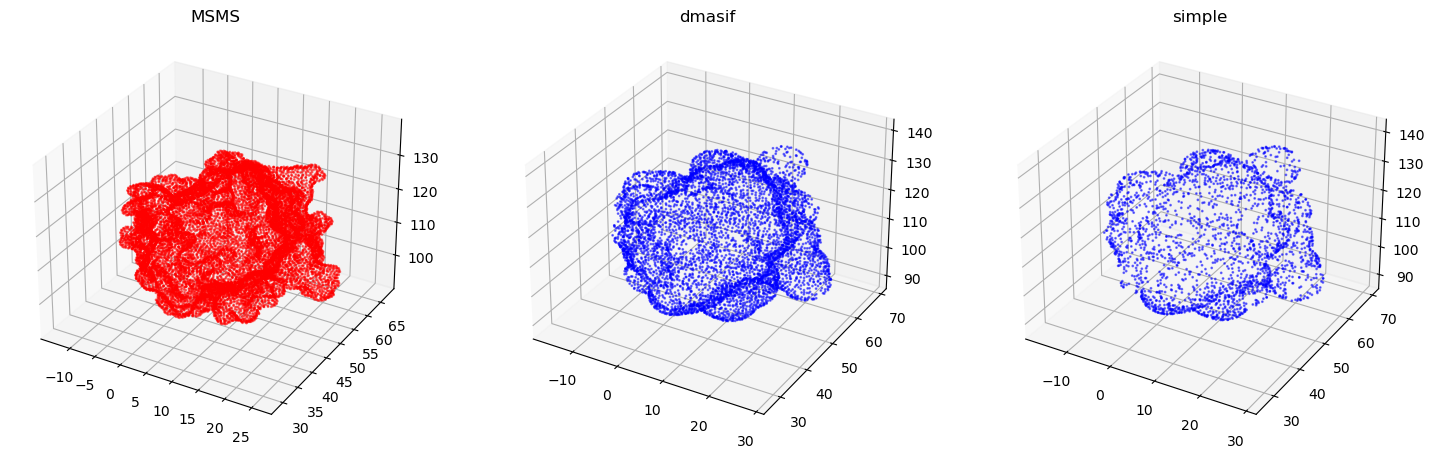

In [61]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(*msms_vert.T, s=1, color='red',alpha=0.5)
ax.set_title('MSMS')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(*dmasif_vert.T, s=1, color='blue',alpha=0.5)
ax.set_title('dmasif')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(*s_vert.T, s=1, color='blue',alpha=0.5)
ax.set_title('simple')


print('MSMS point number:', msms_vert.shape[0])
print('dMaSIF point number:', dmasif_vert.shape[0])
print('Simple point number:', s_vert.shape[0])



In [39]:
import plotly.express as px

fig=px.scatter_3d(x=dataset[0]['atom_xyz'][:,0].detach(),
                  y=dataset[0]['atom_xyz'][:,1].detach(),
                  z=dataset[0]['atom_xyz'][:,2].detach(), 
                  size=dataset[0]['atom_rad'].detach()*10)
fig.update_layout(
    autosize=False, 
    width=800, 
    height=400,
    scene = dict(
        xaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
        zaxis = dict(showgrid=False, zeroline=False, showticklabels=False),
    )
)

In [191]:
dataset[0].keys()

dict_keys(['sequence', 'target_xyz', 'target_normals', 'bb_xyz', 'atom_xyz', 'atom_types', 'atom_rad'])